# UN Peacekeeping Contributions – Final Project

Team members : Yijia ZENG, Thibault GAUTHÉ, Nathan GEORGES, Thomas JIN, Zilong XU

Dataset : Humanitarian Aid : Country level data / Personnel 

### Dataset Description

This dataset contains monthly peacekeeping personnel contributions from each UN member country
between November 1990 and 2012. Each row represents one country’s contribution in a specific month,
including the number of troops, police, and experts sent to UN peacekeeping missions.  

The dataset also includes a regional classification for each contributor, enabling both temporal
analysis (changes over time) and spatial analysis (differences across world regions).  

Key columns include:  
- **Date** – Month and year of the contribution  
- **Contributor** – Country name  
- **Troop / Police / EOM Contributions** – Different personnel categories  
- **Total Contributions** – Total number of personnel contributed  
- **Contributor Region** – Geographic region of the contributor  



# 1. Import libraries

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px  
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
from dash import Dash, dcc, html

# Suppress warnings
warnings.filterwarnings('ignore')

# 2. Function definitions

### Load data: Function for reading a CSV file.

Input: file_path (str) - the path to the csv file

Output: pandas DataFrame containing the loaded data

In [3]:
def load_data(file_path):
    return pd.read_csv(file_path)

### Preprocess data: Cleans the dataframe: converts dates and fills missing values.

Input: df (pandas DataFrame) - raw dataframe with potential missing values
    
Output: pandas DataFrame - cleaned dataframe with datetime dates and filled missing values

In [3]:
def preprocess_data(df):
    """
    Cleans the dataframe: converts dates and fills missing values.
    Input: df (pandas DataFrame) - raw dataframe with potential missing values
    Output: pandas DataFrame - cleaned dataframe with datetime dates and filled missing values
    """
    # Convert Date column to datetime objects
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Fill NaN values with 0 for numerical contribution columns
    fill_cols = ['Troop Contributions', 'Police Contributions', 
                 'EOM Contributions', 'Total Contributions']
    df[fill_cols] = df[fill_cols].fillna(0)
    
    return df

### Explore data structure: Performs the required data summarization.

Input: The dataframe.

Output: None (prints info).

In [4]:
def explore_data_structure(df):
    print("--- Data Types ---")
    print(df.dtypes)
    print("\n--- Missing Values ---")
    print(df.isnull().sum())
    print("\n--- Descriptive Statistics ---")
    print(df.describe())

### Indicator 1: Evolution of Total Contributions over time.

Input: df (pandas DataFrame) - preprocessed dataframe with Date and Total Contributions columns

Output: pandas DataFrame with Date and aggregated Total Contributions

In [5]:
def get_global_trend(df):
    trend = df.groupby('Date')['Total Contributions'].sum().reset_index()
    return trend

### Indicator 2: Top n contributing countries (historical sum).

Input: df (pandas DataFrame) - preprocessed dataframe; n (int) - number of top contributors to return (default=10)

Output: pandas DataFrame with Contributor and Total Contributions for top n countries

In [6]:
def get_top_contributors(df, n=10):
    top = df.groupby('Contributor')['Total Contributions'].sum().nlargest(n).reset_index()
    return top

### Indicator 3: Total split between Troops, Police, and EOM.

Input: df (pandas DataFrame) - preprocessed dataframe with contribution type columns

Output: pandas DataFrame with Type and Count columns showing distribution

In [7]:
def get_contribution_composition(df):
    # Summing up the specific columns
    composition = df[['Troop Contributions', 'Police Contributions', 'EOM Contributions']].sum().reset_index()
    composition.columns = ['Type', 'Count'] # Rename for easier plotting
    return composition

### Indicator 4: Total contributions grouped by Region.

Input: df (pandas DataFrame) - preprocessed dataframe with Contributor Region column

Output: pandas DataFrame with Contributor Region and Total Contributions

In [8]:
def get_regional_distribution(df):
    region_dist = df.groupby('Contributor Region')['Total Contributions'].sum().reset_index()
    return region_dist

### Indicator 5: Normalized contributions showing each country's share of total contributions as a percentage.

Input: df (pandas DataFrame) - preprocessed dataframe with Contributor and Total Contributions columns

Output: pandas DataFrame with Contributor and Share_Percentage columns for top contributors

In [9]:
def get_normalized_contributions(df):
    # Calculate total contributions per country
    country_totals = df.groupby('Contributor')['Total Contributions'].sum().reset_index()
    # Calculate global total
    global_total = country_totals['Total Contributions'].sum()
    # Calculate percentage share
    country_totals['Share_Percentage'] = (country_totals['Total Contributions'] / global_total) * 100
    # Sort by share and get top 10
    norm_df = country_totals.nlargest(10, 'Share_Percentage')[['Contributor', 'Share_Percentage']]
    return norm_df

### Indicator 6: TEMPORAL ANALYSIS: Forecasts future peacekeeping contributions using exponential smoothing.

Input: df (pandas DataFrame) - preprocessed dataframe with Date and Total Contributions periods (int) - number of months to forecast ahead

Output: tuple (historical_df, forecast_df) - historical data and forecasted values

In [10]:
def forecast_contributions(df, periods=12):
    # Aggregate by month for time series
    monthly_data = df.groupby(pd.Grouper(key='Date', freq='MS'))['Total Contributions'].sum().reset_index()
    monthly_data = monthly_data[monthly_data['Total Contributions'] > 0]  # Remove zeros
    
    # Fit Exponential Smoothing model (Holt-Winters)
    model = ExponentialSmoothing(
        monthly_data['Total Contributions'], 
        seasonal_periods=12,
        trend='add',
        seasonal='add'
    )
    fitted_model = model.fit()
    
    # Make predictions
    forecast = fitted_model.forecast(steps=periods)
    
    # Create forecast dataframe
    last_date = monthly_data['Date'].max()
    forecast_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=periods, freq='MS')
    forecast_df = pd.DataFrame({
        'Date': forecast_dates,
        'Forecasted_Contributions': forecast.values
    })
    
    return monthly_data, forecast_df, fitted_model

### Indicator 7: SPATIAL ANALYSIS: Country Clustering by Contribution Patterns (Top 30).

Input: df (pandas DataFrame) - preprocessed dataframe n_clusters (int) - number of clusters to create

Output: pandas DataFrame with Contributor, cluster assignments, and contribution metrics

### Indicator8: Spatial Analysis – Cluster Distribution Across Regions. Uses the same country clusters as Indicator 7, but aggregates them by world region. 

In [11]:
def spatial_clustering(df, n_clusters=4):
    # Aggregate data by country
    country_features = df.groupby('Contributor').agg({
        'Total Contributions': ['sum', 'mean', 'std'],
        'Troop Contributions': 'sum',
        'Police Contributions': 'sum',
        'EOM Contributions': 'sum',
        'Contributor Region': 'first'
    }).reset_index()
    
    # Flatten column names
    country_features.columns = ['Contributor', 'Total_Sum', 'Total_Mean', 'Total_Std', 
                                 'Troops_Sum', 'Police_Sum', 'EOM_Sum', 'Region']
    
    # Fill NaN std with 0
    country_features['Total_Std'] = country_features['Total_Std'].fillna(0)
    
    # Select features for clustering
    feature_cols = ['Total_Sum', 'Total_Mean', 'Total_Std', 'Troops_Sum', 'Police_Sum', 'EOM_Sum']
    X = country_features[feature_cols]
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Apply K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    country_features['Cluster'] = kmeans.fit_predict(X_scaled)
    
    # Add cluster labels
    country_features['Cluster_Label'] = country_features['Cluster'].map({
        0: 'Low Contributors',
        1: 'Medium Contributors', 
        2: 'High Contributors',
        3: 'Very High Contributors'
    })
    
    return country_features, kmeans, scaler


# 3. Offline Dashboard Definition (8 indicators)

In [12]:
def create_dashboard(trend_df, top_df, comp_df, reg_df, norm_df,
                     monthly_data, forecast_df, cluster_df):
    """
    Build a Dash dashboard with 8 indicators:
      1. Global trend over time
      2. Top contributing countries
      3. Composition of contributions
      4. Regional distribution
      5. Normalized contributions (% share)
      6. Temporal forecast
      7. Spatial clustering (top 30 countries)
      8. Cluster distribution across regions
    """

    # ----- Recreate the main figures (no .show() here) -----

    # Indicator 1 – Global Trend
    fig1 = px.line(
        trend_df,
        x="Date",
        y="Total Contributions",
        title="Indicator 1: Global Peacekeeping Personnel Trend (1990–2017)"
    )

    # Indicator 2 – Top 10 Countries
    fig2 = px.bar(
        top_df,
        x="Total Contributions",
        y="Contributor",
        orientation="h",
        title="Indicator 2: Top 10 Contributing Countries (Historical Total)"
    )

    # Indicator 3 – Composition Pie Chart
    fig3 = px.pie(
        comp_df,
        values="Count",
        names="Type",
        title="Indicator 3: Composition of Peacekeeping Forces",
        color_discrete_sequence=px.colors.sequential.RdBu
    )

    # Indicator 4 – Regional Distribution
    fig4 = px.bar(
        reg_df,
        x="Contributor Region",
        y="Total Contributions",
        title="Indicator 4: Contributions by Region",
        color="Contributor Region"
    )

    # Indicator 5 – Normalized Contributions
    fig5 = px.bar(
        norm_df,
        x="Share_Percentage",
        y="Contributor",
        orientation="h",
        title="Indicator 5: Normalized Contributions (% of Global Total)",
        text="Share_Percentage",
        labels={"Share_Percentage": "Share of Total Contributions (%)"}
    )
    fig5.update_traces(texttemplate="%{text:.2f}%", textposition="outside")

    # Indicator 6 – Temporal Forecast
    fig6 = px.line(
        title="Indicator 6: Temporal Analysis – Peacekeeping Contributions Forecast (24 months)"
    )
    fig6.add_scatter(
        x=monthly_data["Date"],
        y=monthly_data["Total Contributions"],
        mode="lines",
        name="Historical Data",
        line=dict(color="blue")
    )
    fig6.add_scatter(
        x=forecast_df["Date"],
        y=forecast_df["Forecasted_Contributions"],
        mode="lines",
        name="Forecast",
        line=dict(color="red")
    )
    fig6.update_xaxes(title_text="Date")
    fig6.update_yaxes(title_text="Total Contributions")

    # Indicator 7 – Spatial Clustering (Top 30)
    top_30 = cluster_df.nlargest(30, "Total_Sum")
    fig7 = px.scatter(
        top_30,
        x="Total_Sum",
        y="Total_Mean",
        color="Cluster_Label",
        size="Troops_Sum",
        hover_data=["Contributor", "Region"],
        title="Indicator 7: Spatial Analysis – Country Clustering by Contribution Patterns (Top 30)",
        labels={
            "Total_Sum": "Total Contributions (Sum)",
            "Total_Mean": "Average Contribution per Period"
        }
    )

    # Indicator 8 – Cluster Distribution Across Regions
    cluster_region = cluster_df.groupby(["Cluster_Label", "Region"]).size().reset_index(name="Count")
    fig8 = px.bar(
        cluster_region,
        x="Cluster_Label",
        y="Count",
        color="Region",
        title="Indicator 8: Spatial Analysis – Cluster Distribution Across Regions",
        barmode="stack"
    )

    # ----- Build Dash app -----
    app = Dash(__name__)

    app.layout = html.Div(
        style={"backgroundColor": "white"},
        children=[
            html.H1("UN Peacekeeping Contributions Dashboard"),

            html.P(
                "Goal: Provide a clear overview of how countries and regions "
                "contribute personnel to UN peacekeeping missions over time."
            ),
            html.P(
                "Dataset: Country-level UN peacekeeping personnel contributions "
                "(Humanitarian Data Exchange)."
            ),
            html.P(
                "Team members: Yijia ZENG, Thibault GAUTHÉ, Nathan GEORGES, Thomas JIN, Zilong XU"
            ),

            html.Hr(),

            html.H2("Indicator 1 – Global Trend"),
            dcc.Graph(id="indicator-1-global-trend", figure=fig1),

            html.H2("Indicator 2 – Top 10 Contributing Countries"),
            dcc.Graph(id="indicator-2-top-countries", figure=fig2),

            html.H2("Indicator 3 – Composition of Contributions"),
            dcc.Graph(id="indicator-3-composition", figure=fig3),

            html.H2("Indicator 4 – Regional Distribution"),
            dcc.Graph(id="indicator-4-regions", figure=fig4),

            html.H2("Indicator 5 – Normalized Contributions"),
            dcc.Graph(id="indicator-5-normalized", figure=fig5),

            html.H2("Indicator 6 – Temporal Forecast (24 months)"),
            dcc.Graph(id="indicator-6-forecast", figure=fig6),

            html.H2("Indicator 7 – Spatial Clustering (Top 30 Countries)"),
            dcc.Graph(id="indicator-7-clusters", figure=fig7),

            html.H2("Indicator 8 – Cluster Distribution Across Regions"),
            dcc.Graph(id="indicator-8-cluster-region", figure=fig8),
        ]
    )

    return app


# 4. Main Execution Block 

In [18]:
if __name__ == "__main__":
    # datacolec and cleaning
    file_path = "country_level_data.csv"
    
    # Load and clean
    print(43*"=")
    print("=== PEACEKEEPING CONTRIBUTIONS ANALYSIS ===")
    print(43*"=")
    df_raw = load_data(file_path)
    df = preprocess_data(df_raw)

    # modification
    print("--- DATA EXPLORATION ---")
    explore_data_structure(df)
    
    print(f"\nData loaded. Shape: {df.shape}")
    print(f"Date range: {df['Date'].min().date()} to {df['Date'].max().date()}")

    # --- Compute Indicators ---
    print(43*"=")
    print("Computing indicators...")
    trend_df = get_global_trend(df)
    top_df = get_top_contributors(df, n=10)
    comp_df = get_contribution_composition(df)
    reg_df = get_regional_distribution(df)
    norm_df = get_normalized_contributions(df)
    print("Indicators computed.")
    
    # --- TEMPORAL ANALYSIS: Forecasting ---
    print(43*"=")
    print("Performing temporal forecasting...")
    monthly_data, forecast_df, model = forecast_contributions(df, periods=24)
    print(f"Forecast generated for next 24 months")
    
    # --- SPATIAL ANALYSIS: Clustering ---
    print(43*"=")
    print("Performing spatial clustering...")
    cluster_df, kmeans_model, scaler = spatial_clustering(df, n_clusters=4)
    print(f"Countries clustered into 4 groups")

    print("\n=== ANALYSIS COMPLETE ===")
    print(f"\nTemporal Forecast Summary:")
    print(f"  - Last historical value: {monthly_data['Total Contributions'].iloc[-1]:,.0f}")
    print(f"  - Forecasted 6-month avg: {forecast_df['Forecasted_Contributions'].head(6).mean():,.0f}")
    print(f"  - Forecasted 24-month avg: {forecast_df['Forecasted_Contributions'].mean():,.0f}")
    
    print(f"\nSpatial Clustering Summary:")
    print(cluster_df['Cluster_Label'].value_counts().sort_index())
    
    # --- DASHBOARD ---
    # Set this flag to True when you want to launch the dashboard
    run_dash = True  # if True,  Dash server will start

    if run_dash:
        app = create_dashboard(
            trend_df=trend_df,
            top_df=top_df,
            comp_df=comp_df,
            reg_df=reg_df,
            norm_df=norm_df,
            monthly_data=monthly_data,
            forecast_df=forecast_df,
            cluster_df=cluster_df
        )
        # Dash

        HOST = "127.0.0.1"
        PORT = 8050
        print(43*"=")
        print("\n\n\n\nDashboard is running")
        print(f"Dash is running at: http://{HOST}:{PORT}/")
        app.run(host=HOST, port=PORT, debug=False)

=== PEACEKEEPING CONTRIBUTIONS ANALYSIS ===
--- DATA EXPLORATION ---
--- Data Types ---
Date                                 datetime64[ns]
Contributor                                  object
Contributor ISO-3                            object
Contributor Capital Longitude               float64
Contributor Capital Latitude                float64
Contributor Continent                        object
Contributor Region                           object
Contributor UN Bloc                          object
Contributor - P5, G4 or A3                   object
Contributor - NAM                             int64
Contributor - G77                             int64
Contributor - AU                              int64
Contributor - Arab League                     int64
Contributor - OIC                             int64
Contributor - CIS                             int64
Contributor - G20                             int64
Contributor - EU                              int64
Number of Missions Contribut

# Interpretation

### Indicator 1 — Global Trend

Purpose:
To see how total peacekeeping contributions changed over time.

Results:
The global contribution level rose sharply in the mid-1990s, then dipped around the year 2000.
After 2003, contributions increased steadily and reached their highest levels between 2010 and 2015.
Overall, the long-term trend is upward despite some short-term fluctuations.

### Indicator 2 — Top 10 Contributing Countries

Purpose:
To identify which countries have contributed the most peacekeeping personnel overall.

Results:
South Asian countries like Pakistan, Bangladesh, and India dominate the top contributors list.
These countries contribute far more than many Western states.
Their long-term and consistent involvement highlights their major role in UN peacekeeping operations.


### Indicator 3 — Composition of Peacekeeping Forces

Purpose:
To understand what types of personnel make up UN peacekeeping forces.

Results:
Troops make up the overwhelming majority of contributions.
Police contributions are much smaller, and expert personnel (EOM) represent only a tiny portion.
This shows that peacekeeping missions rely heavily on military manpower.


### Indicator 4 — Contributions by Region

Purpose:
To compare peacekeeping contributions across world regions.

Results:
Central and Eastern Africa contribute extremely large numbers overall.
South Asia and Western Asia also have strong participation.
Meanwhile, regions like Northern America or Oceania contribute relatively little.


### Indicator 5 — Normalized Contributions (% of Global Total)

Purpose:
To compare countries fairly by looking at their share of global contributions.

Results:
Pakistan, Bangladesh, and India together account for a significant portion of all global contributions.
Smaller contributors like Rwanda or France play a role but at much lower percentages.
The ranking shows clear inequality in how much different countries participate.


### Indicator 6 — Temporal Forecast (24-month prediction)

Purpose:
To estimate how peacekeeping contributions may evolve in the near future.

Results:
The forecast suggests contributions will slightly decline from recent peak levels.
There is no sign of dramatic growth or sudden collapse.
This stable outlook indicates predictable personnel needs for upcoming UN missions.


### Indicator 7 — Country Clustering (Top 30)

Purpose:
To group countries with similar peacekeeping contribution behaviors.

Results:
Very-high contributors cluster clearly on the right with high totals and high averages.
Medium contributors form a middle group with moderate activity.
Low contributors stay on the left, showing smaller and less frequent participation.


### Indicator 8 — Cluster Distribution Across Regions

Purpose:
To see how contribution clusters are distributed across world regions.

Results:
Low-contributor countries appear in almost every region.
Very-high contributors are concentrated in only a few regions, mainly South Asia and parts of Africa.
Some regions show a diverse mix, while others lean heavily toward low-contribution behavior.

# 5. External dataset

In [4]:
df = load_data("country_level_data.csv")

In [5]:
import requests
import pandas as pd

url = "https://api.worldbank.org/v2/country/all/indicator/NY.GDP.MKTP.CD?format=json&per_page=20000"

response = requests.get(url)
json_data = response.json()

data = json_data[1]

gdp_df = pd.DataFrame(data)

gdp_df = gdp_df[["country", "date", "value"]]
gdp_df["country"] = gdp_df["country"].apply(lambda x: x["value"])
gdp_df = gdp_df.rename(columns={
    "date": "year",
    "value": "gdp"
})

gdp_df["year"] = gdp_df["year"].astype(int)

In [6]:
gdp_df.head()

,country,year,gdp
0,Africa Eastern and Southern,2024,1.205974e+12
1,Africa Eastern and Southern,2023,1.133818e+12
2,Africa Eastern and Southern,2022,1.191639e+12
3,Africa Eastern and Southern,2021,1.085605e+12
4,Africa Eastern and Southern,2020,9.334072e+11


In [7]:
country_mapping = {
    "United States of America": "United States",
    "Russian Federation": "Russia",
    "Republic of Korea": "Korea, Rep.",
    "Iran": "Iran, Islamic Rep.",
    "Cote d Ivoire": "Côte d'Ivoire",
    "DR Congo": "Congo, Dem. Rep.",
    "The former Yugoslav Republic of Macedonia": "North Macedonia",
    "Macedonia": "North Macedonia",
    "Cape Verde": "Cabo Verde",
    "Bahamas": "Bahamas, The",
    "Gambia": "Gambia, The",
    "Egypt": "Egypt, Arab Rep.",
    "Yemen": "Yemen, Rep.",
    "Venezuela": "Venezuela, RB",
    "Slovakia": "Slovak Republic",
    "Vietnam": "Viet Nam",
    "Congo": "Congo, Rep.",
    "Czech Republic": "Czechia",
    "Serbia": "Serbia",            
    "Turkey": "Turkiye",
    "Brunei": "Brunei Darussalam",
    "Lithuania": "Lithuania",     
    "Kyrgyzstan": "Kyrgyz Republic",
}

df["year"] = pd.to_datetime(df["Date"]).dt.year
df["country_gdp"] = df["Contributor"].replace(country_mapping)

merged = df.merge(
    gdp_df,
    left_on=["country_gdp", "year"],
    right_on=["country", "year"],
    how="left"
)

In [8]:
merged[merged["gdp"].isna()]["Contributor"].unique()

array(['Russian Federation', 'Serbia', 'Lithuania', 'Cote d Ivoire'],
      dtype=object)

In [9]:
ignore_countries = {"Russian Federation", "Serbia", "Lithuania", "Cote d Ivoire"}

df["Date"] = pd.to_datetime(df["Date"])
df["year"] = df["Date"].dt.year

filtered = merged[
    (~merged["Contributor"].isin(ignore_countries)) &
    (merged["gdp"].notna()) &
    (merged["year"].between(1990, 2012))
].copy()

year_country = (
    filtered.groupby(["country_gdp", "year"], as_index=False)
            .agg(un_contrib=("Total Contributions", "sum"),
                 gdp=("gdp", "mean"))
            .rename(columns={"country_gdp": "country"})
)

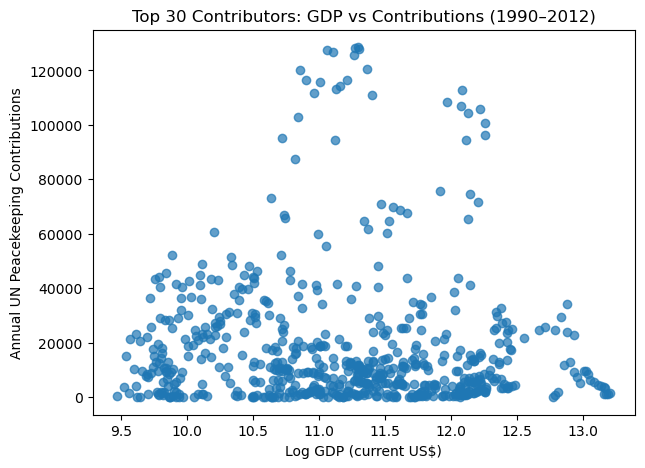

In [10]:
import numpy as np
import matplotlib.pyplot as plt

plot_df = year_country.dropna(subset=["gdp", "un_contrib"]).copy()
plot_df["log_gdp"] = np.log10(plot_df["gdp"])

top30 = (
    plot_df.groupby("country")["un_contrib"].sum()
           .sort_values(ascending=False).head(30).index
)
plot30 = plot_df[plot_df["country"].isin(top30)]

plt.figure(figsize=(7,5))
plt.scatter(plot30["log_gdp"], plot30["un_contrib"], alpha=0.7)
plt.xlabel("Log GDP (current US$)")
plt.ylabel("Annual UN Peacekeeping Contributions")
plt.title("Top 30 Contributors: GDP vs Contributions (1990–2012)")
plt.show()

## Interpretation

We incorporate GDP (current US$) from the World Bank as an external dataset to interpret cross-country differences in UN peacekeeping contributions. After excluding countries with unmatched GDP records and aggregating monthly data into yearly totals (1990–2012), the scatter plot suggests that economic size alone does not determine contribution levels. Several mid-GDP countries contribute disproportionately large numbers of personnel, while some high-GDP countries contribute relatively little. This indicates that factors beyond economic capacity—such as policy priorities, regional security context, and institutional commitments—likely shape participation in UN peacekeeping.